# Cells for running the package simulations in order to check its results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.integrate import solve_ivp
from scipy_dae.integrate import solve_dae
from benchmark_systems.models import (
    dc_motor,
    pendulum,
    cart_pendulum,
    multimass_spring,
    double_cart_pendulum,
    multilevel_cart_pendulum,
    quadrotor_dae,
    quadrotor_ode,
    cstr,
    batch_bioreactor,
    johansson,
    oil_well
)

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (12, 6)})

### DC-Motor

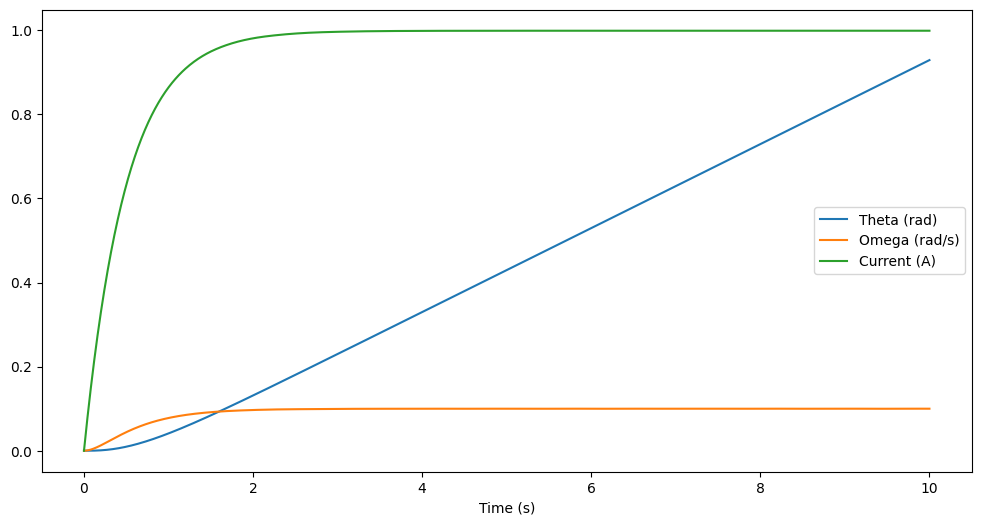

In [3]:
dcmotor_states = solve_ivp(lambda t, x: dc_motor(t, x, R=1, L=0.5, Kt=0.01, Ke=0.01, J=0.02, b=0.1, u=1),
                            t_span=(0, 10), y0=[0, 0, 0], t_eval=np.linspace(0, 10, 1000))

for i, label in enumerate(['Theta (rad)', 'Omega (rad/s)', 'Current (A)']):
    plt.plot(dcmotor_states.t, dcmotor_states.y[i], label=label)
plt.xlabel('Time (s)')
plt.legend()

### Simple pendulum

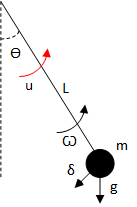

States: $x = \begin{bmatrix} \theta \\ \omega \end{bmatrix}$; Control actions: $u$

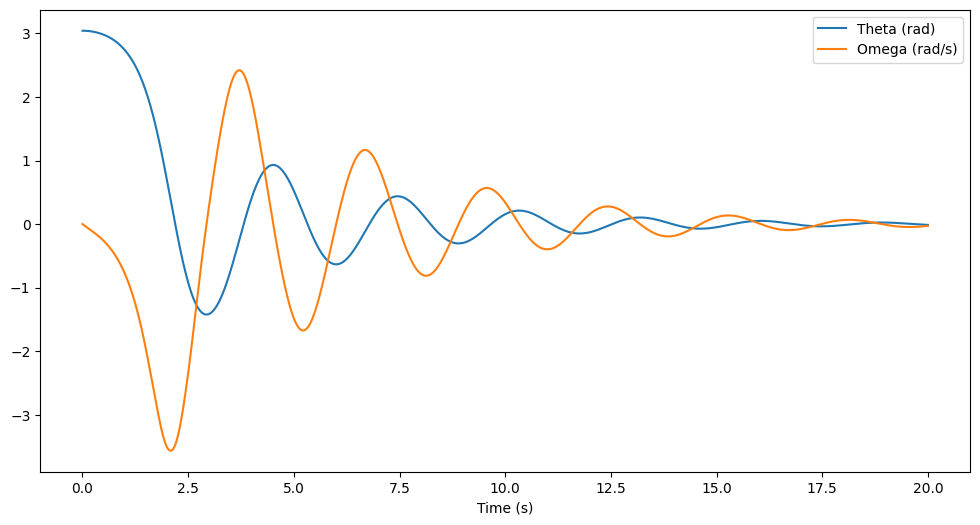

In [4]:
pendulum_states = solve_ivp(lambda t, x: pendulum(t, x, m=1, L=2, drag=0.5, u=0),
                            t_span=(0, 20), y0=[np.pi-0.1, 0], t_eval=np.linspace(0, 20, 1000))

for i, label, in enumerate(['Theta (rad)', 'Omega (rad/s)']):
    plt.plot(pendulum_states.t, pendulum_states.y[i], label=label)
plt.xlabel('Time (s)')
plt.legend()

### Cart-Pendulum

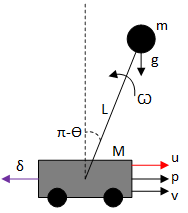

States: $x = \begin{bmatrix} p \\ v \\ \theta \\ \omega \end{bmatrix}$; Control actions: $u$

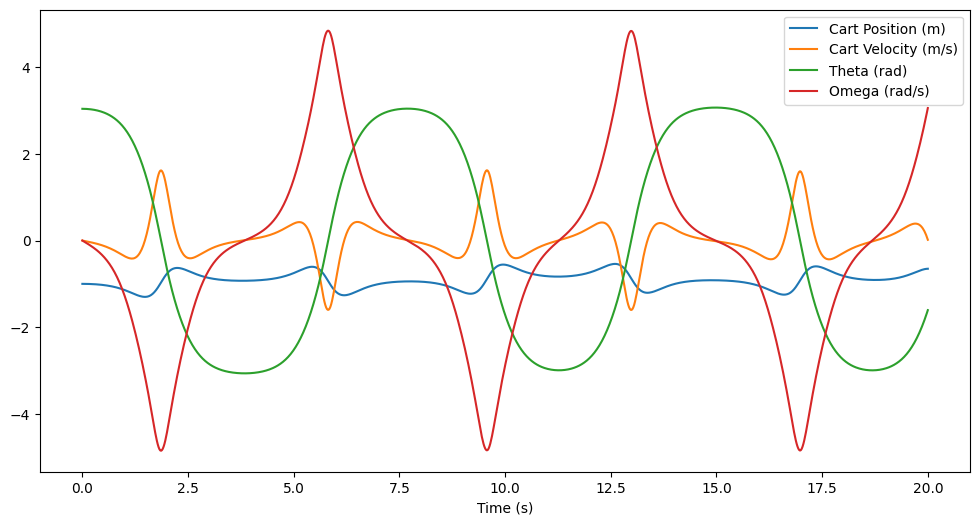

In [5]:
cp_states = solve_ivp(lambda t, x: cart_pendulum(t, x, m=1, M=5, L=2, drag=0, u=0),
                            t_span=(0, 20), y0=[-1, 0, np.pi-0.1, 0], t_eval=np.linspace(0, 20, 1000))

for i, label in enumerate(['Cart Position (m)', 'Cart Velocity (m/s)', 'Theta (rad)', 'Omega (rad/s)']):
    plt.plot(cp_states.t, cp_states.y[i], label=label)
plt.xlabel('Time (s)')
plt.legend()

### Double Inverted Pendulum

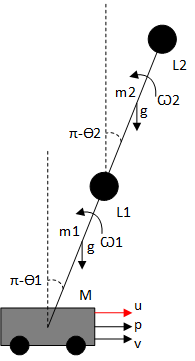

States: $x = \begin{bmatrix} p \\ \theta_1 \\ \theta_2 \\ v \\ \omega_1 \\ \omega_2 \end{bmatrix}$; Control actions: $u$

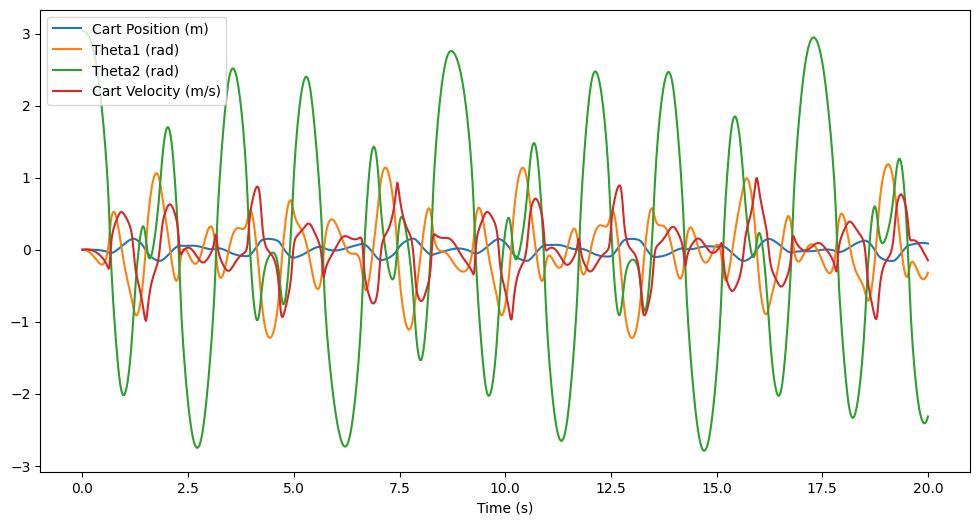

In [4]:
dip_states = solve_dae(lambda t, x, z: double_cart_pendulum(t, x, z, M=0.6, m1=0.2, m2=0.2, L1=0.5, L2=0.5, u=0),
                       t_span=(0, 20), y0=[0, 0, np.pi-0.1, 0, 0, 0], y_dot0=np.zeros(6), t_eval=np.linspace(0, 20, 1000))

for i, label in enumerate(['Cart Position (m)', 'Theta1 (rad)', 'Theta2 (rad)', 'Cart Velocity (m/s)']):
    plt.plot(dip_states.t, dip_states.y[i], label=label)
plt.xlabel('Time (s)')
plt.legend()

### Triple Inverted Pendulum

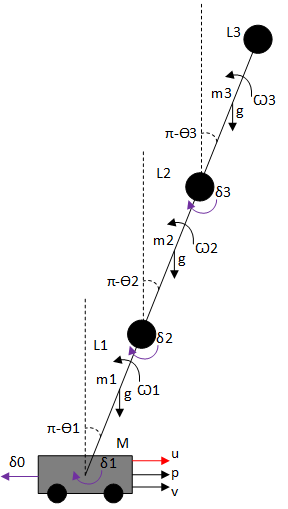

States: $x = \begin{bmatrix} p \\ \theta_1 \\ \theta_2 \\ \theta_3 \\ v \\ \omega_1 \\ \omega_2 \\ \omega_3 \end{bmatrix}$; Control actions: $u$

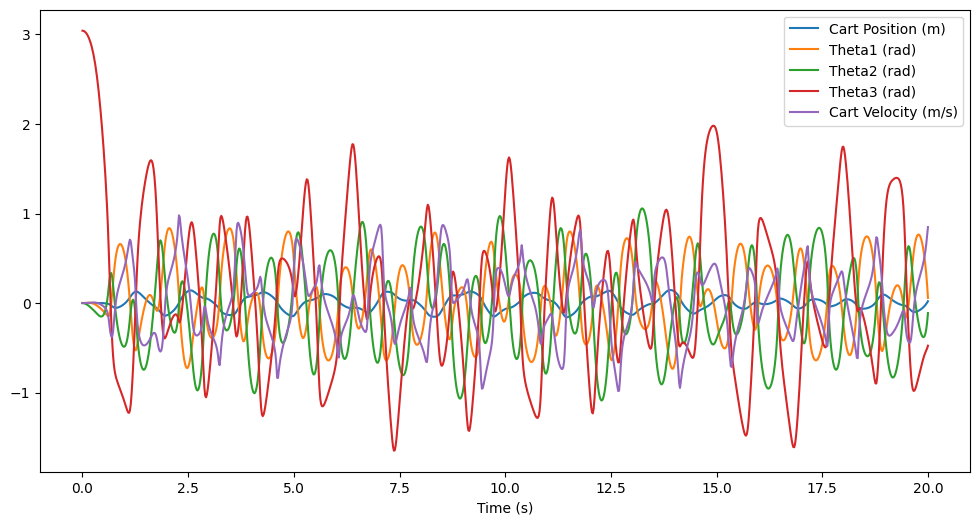

In [7]:
tip_states = solve_dae(lambda t, x, z: multilevel_cart_pendulum(t, x, z, M=0.6, m=[0.2]*3, L=[0.5]*3, u=0),
                       t_span=(0, 20), y0=[0, 0, 0, np.pi-0.1, 0, 0, 0, 0], y_dot0=np.zeros(8), t_eval=np.linspace(0, 20, 1000))

for i, label in enumerate(['Cart Position (m)', 'Theta1 (rad)', 'Theta2 (rad)', 'Theta3 (rad)', 'Cart Velocity (m/s)']):
    plt.plot(tip_states.t, tip_states.y[i], label=label)
plt.xlabel('Time (s)')
plt.legend()

### Multimass Spring System

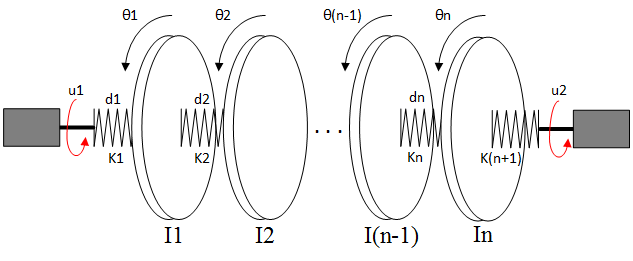

States: $x = \begin{bmatrix} \theta_1 \\ \theta_2 \\ \dots \\ \theta_n \\
\dot{\theta}_1 \\ \dot{\theta}_2 \\ \dots \\ \dot{\theta}_n \end{bmatrix}$; Control actions: $u = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$

In [3]:
multimass_params = {
    'I': [2.25*1e-4]*3, # Inertia of each mass
    'K': np.array([2.697,  2.66,  3.05, 2.86])*1e-3, # Spring constants
    'd': np.array([6.78,  8.01,  8.82])*1e-5, # Damping constants
}

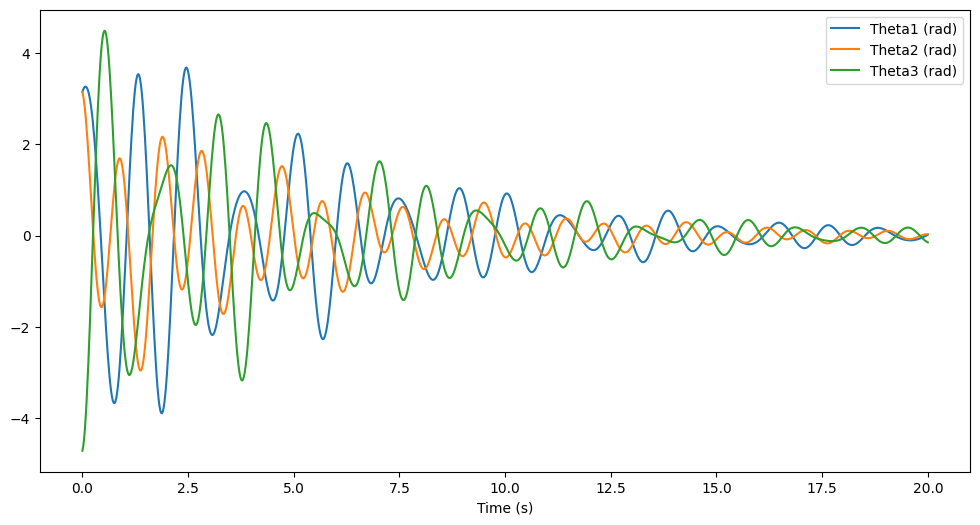

In [4]:
damper_states = solve_ivp(lambda t, x: multimass_spring(t, x, **multimass_params, u=[0,0]),
                            t_span=(0, 20), y0=np.pi*np.array([1, 1, -1.5, 1, -1, 1]), t_eval=np.linspace(0, 20, 1000))

for i, label in enumerate(['Theta1 (rad)', 'Theta2 (rad)', 'Theta3 (rad)']):
    plt.plot(damper_states.t, damper_states.y[i], label=label)
plt.xlabel('Time (s)')
plt.legend()

### Johansson's 4 tank system

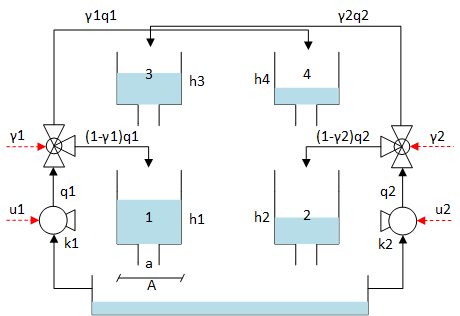

States: $x = \begin{bmatrix} h_1 \\ h_2 \\ h_3 \\ h_4 \end{bmatrix}$; Control actions: $u = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$

In [38]:
johansson_params = {
    'h_max': [25, 25, 20, 20], # cm
    'A' : [389.16] * 4, #cm^2
    'a': [((1.4/2) ** 2) * np.pi] * 4, # cm^2
    'K' : [6.74, 7.94],
    'gamma': [0.7, 0.6] # Non-minimum phase configuration
}

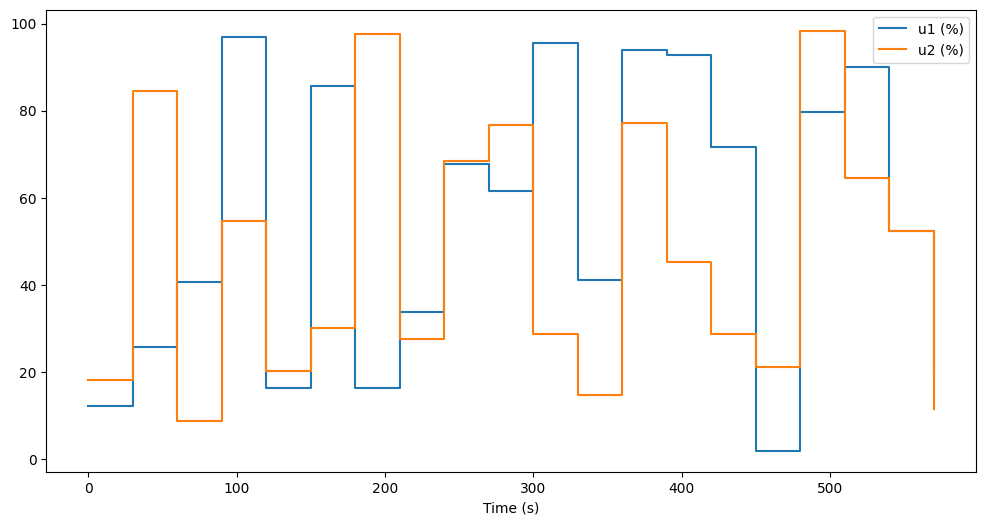

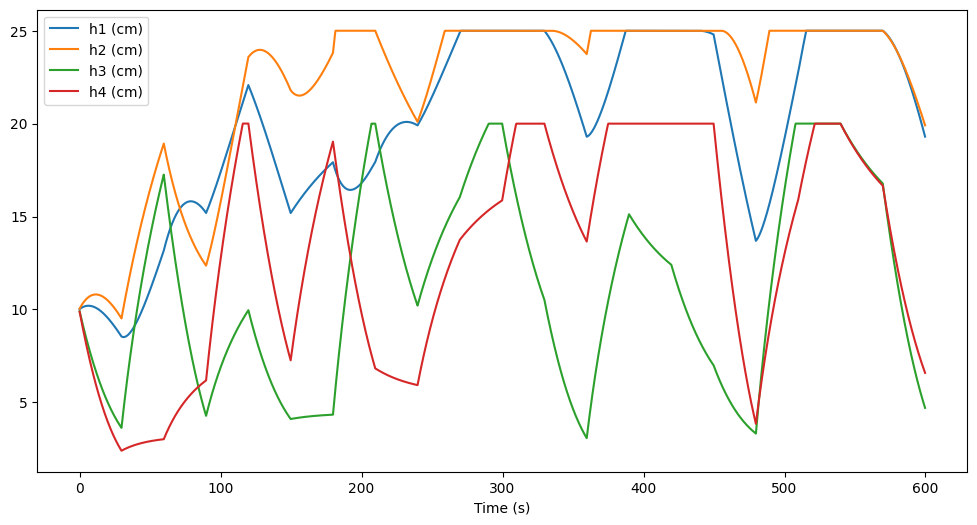

In [39]:
duration = 30 # seconds
Ts = 0.3 # seconds

# 20 random setpoints (0-100) for pump 1 and 2.
rangen = np.random.default_rng(seed=44)
u1, u2 = [rangen.random(20)*100 for _ in range(2)]

# Simulation of the system ... Every setpoint is held for 30 seconds
johansson_states = np.array([[] for _ in range(4)])
for u1_k, u2_k in zip(u1, u2):
    # Solve the system for 30 seconds, taking 100 samples in that interval
    heights = solve_ivp(lambda t, x: johansson(t, x, u=[u1_k, u2_k], **johansson_params),
                            y0 = [10, 10, 10, 10] if johansson_states.size == 0 else johansson_states[:, -1],
                            t_span=(0, duration), t_eval=np.linspace(Ts, duration, int(duration/Ts)), rtol=1e-6)
    # Append the states
    johansson_states = np.hstack([johansson_states, heights.y])

# Plot the setpoints
plt.figure()
plt.step(np.arange(0, 600, 30), u1, label='u1 (%)', where='post')
plt.step(np.arange(0, 600, 30), u2, label='u2 (%)', where='post')
plt.xlabel('Time (s)')
plt.legend()

# Plot heights
plt.figure()
for i, label in enumerate(['h1 (cm)', 'h2 (cm)', 'h3 (cm)', 'h4 (cm)']):
    plt.plot(np.arange(0, 600, 0.3), johansson_states[i], label=label)
plt.xlabel('Time (s)')
plt.legend()

### Batch Bioreactor

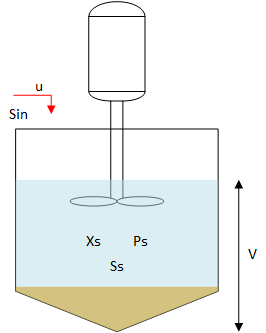

States: $x = \begin{bmatrix} X_s \\ S_s \\ P_s \\ V \end{bmatrix}$; Control actions: $u$

Text(0.5, 0, 'Time (min)')

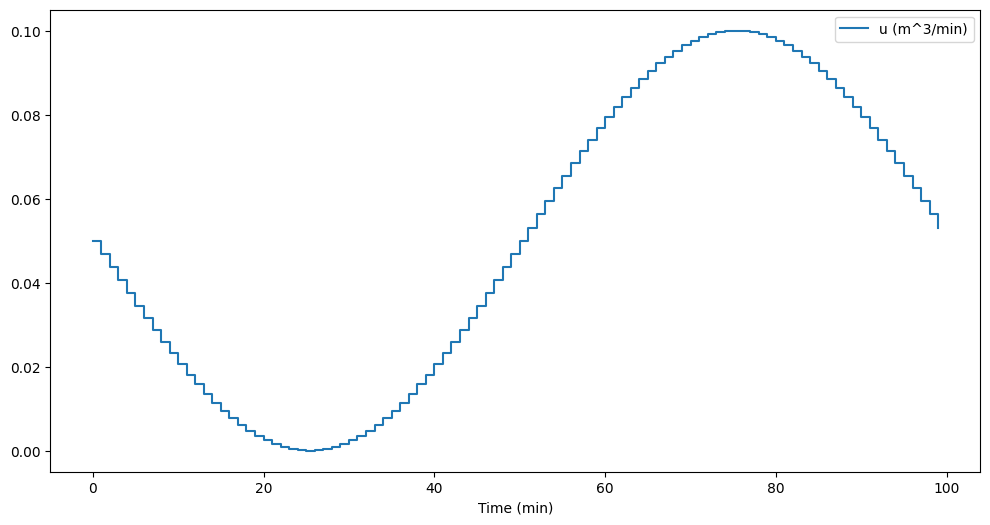

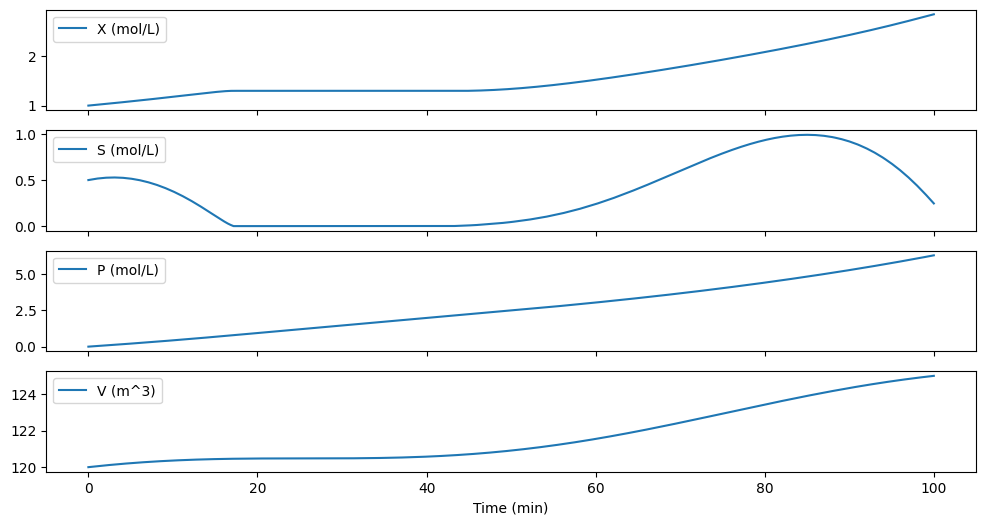

In [40]:
duration = 1 # minutes
Ts = 0.01 # minutes

# Feed flow rate between 0 and 0.1.
k = np.arange(0, 1, 0.01)
u = 0.05*(1 + np.sin(2*np.pi*k - np.pi))

# Simulation of the batch reactor ... Every setpoint is held for 1 minute
batch_states = np.array([[] for _ in range(4)])
for u_k in u:
    # Solve the system for 1 minute, taking 100 samples in that interval
    states = solve_ivp(lambda t, x: batch_bioreactor(t, x, S_in=200, mu_max=0.02, K_m=0.05, K_i=5, v=0.04, Y_x=0.5, Y_p=1.2, u=u_k),
                       y0 = [1, 0.5, 0, 120] if batch_states.size == 0 else batch_states[:, -1],
                       t_span=(0, duration), t_eval=np.linspace(Ts, duration, int(duration/Ts)))
    # Append the states
    batch_states = np.hstack([batch_states, states.y])

# Plot feed flow rate
plt.figure()
plt.step(np.arange(100), u, label='u (m^3/min)', where='post')
plt.xlabel('Time (min)')
plt.legend()

# Plot states
fig, axs = plt.subplots(4, 1, sharex=True)
for i, label in enumerate(['X (mol/L)', 'S (mol/L)', 'P (mol/L)', 'V (m^3)']):
    axs[i].plot(np.arange(0, 100, 0.01), batch_states[i], label=label)
    axs[i].legend()
axs[-1].set_xlabel('Time (min)')

### Continuous Stirred Tank Reactor (CSTR)

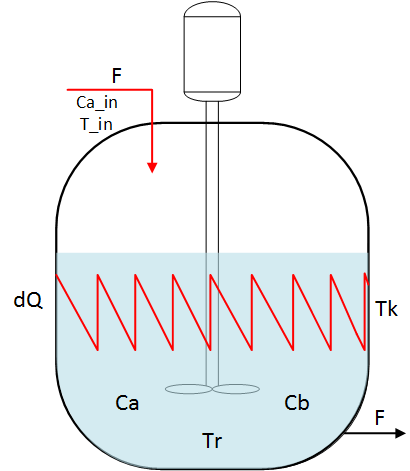

States: $x = \begin{bmatrix} C_a \\ C_b \\ T_r \\ T_k \end{bmatrix}$; Control actions: $u = \begin{bmatrix} F \\ \dot{Q} \end{bmatrix}$

In [41]:
arrhenius_eqs = {
    'K0_ab': 1.287e12, 'Ea_ab': 81.135, 'Hr_ab': 4.2, 
    'K0_bc': 1.287e12, 'Ea_bc': 81.135, 'Hr_bc': -11,
    'K0_ad': 9.043e9, 'Ea_ad': 71.172, 'Hr_ad': -41.85
}
reactor = {
    'rho': 0.9342, 'Cp': 3.01,
    'A': 0.215, 'V': 10, 'K_w': 4032
}
in_flow = {
    'Ca_in': 5.1, 'T_in': 130
}
coolant = {
    'Cp_k': 2, 'm_k': 5
}

Text(0.5, 0, 'Time (h)')

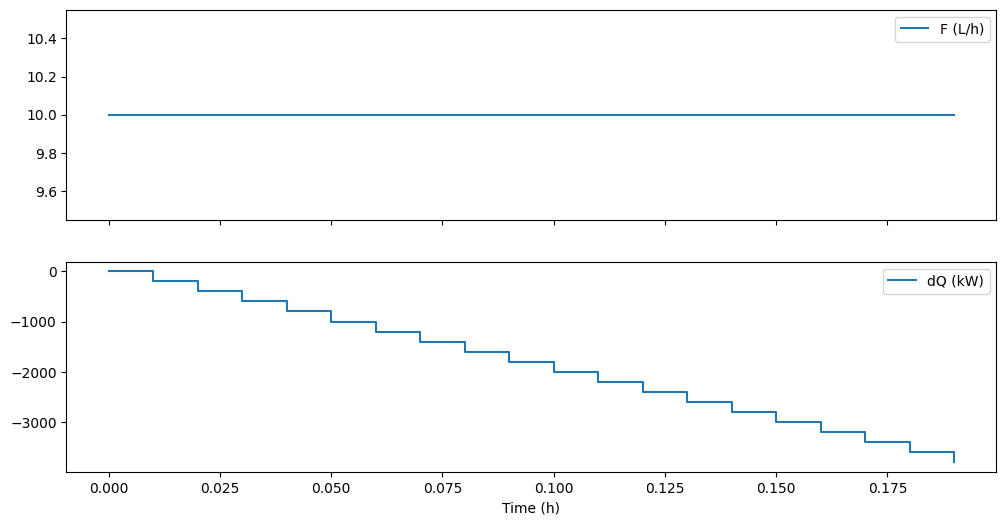

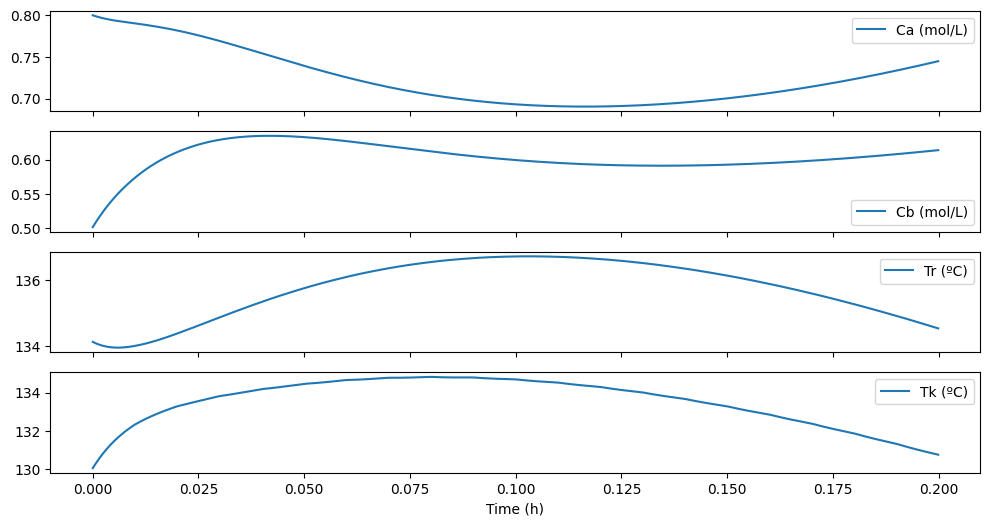

In [42]:
duration = 0.01 # hours
Ts = 0.0001 # hours

# Feed flow and heat flow
t = np.arange(0, 0.2, 0.01)
F = np.ones_like(t) * 10
dQ = -20000 * t
u = np.array([F, dQ]).T

# Simulation of the CSTR ... Every setpoint is held for 0.01 hours
cstr_states = np.array([[] for _ in range(4)])
for F_k, dQ_k in u:
    # Solve the system for 0.01 hours, taking 100 samples in that interval
    states = solve_ivp(lambda t, x: cstr(t, x, **arrhenius_eqs, **reactor, **in_flow, **coolant,
                                         u=[F_k, dQ_k]),
                       y0 = [0.8, 0.5, 134.14, 130] if cstr_states.size == 0 else cstr_states[:, -1],
                       t_span=(0, duration), t_eval=np.linspace(Ts, duration, int(duration/Ts)))
    # Append the states
    cstr_states = np.hstack([cstr_states, states.y])

# Plot feed flow rate and heat flow
fig, axs = plt.subplots(2, 1, sharex=True)
for i, label in enumerate(['F (L/h)', 'dQ (kW)']):
    axs[i].step(t, u[:, i], label=label, where='post')
    axs[i].legend()
axs[-1].set_xlabel('Time (h)')

# Plot states
fig, axs = plt.subplots(4, 1, sharex=True)
for i, label in enumerate(['Ca (mol/L)', 'Cb (mol/L)', 'Tr (ºC)', 'Tk (ºC)']): 
    axs[i].plot(np.arange(0, 0.2, 0.0001), cstr_states[i], label=label)
    axs[i].legend()
axs[-1].set_xlabel('Time (h)')

### Quadrotor

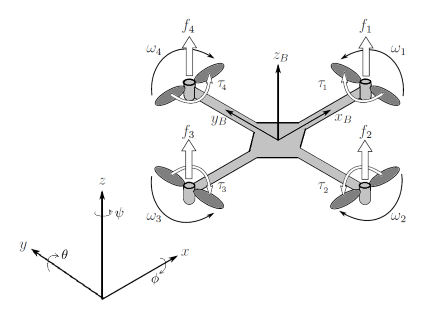

###### Image source: https://es.mathworks.com/help/symbolic/derive-quadrotor-dynamics-for-nonlinearMPC.html

* Newton-Euler model (ODE)
    States: $x = \begin{bmatrix} x \ y \ z \ \phi \ \theta \ \psi \ s \ v \ w \ p \ q \ r \end{bmatrix}^T$; 

* Euler-Lagrange model (DAE)
    States: $x = \begin{bmatrix} x \ y \ z \ \phi \ \theta \ \psi \ \dot{x} \ \dot{y} \ \dot{z} \ \dot{\phi} \ \dot{\theta} \ \dot{\psi} \end{bmatrix}^T$;

Control actions: $u = \begin{bmatrix} \omega_1^2 \ \omega_2^2 \ \omega_3^2 \ \omega_4^2 \end{bmatrix}^T$

In [5]:
quadrotor_params = {
    'Ixx': 1.2, 'Iyy': 1.2, 'Izz': 2.3, 'k': 1, 'L': 0.25, 'm': 2, 'drag': 0.2
}

Text(0.5, 0, 'Time (s)')

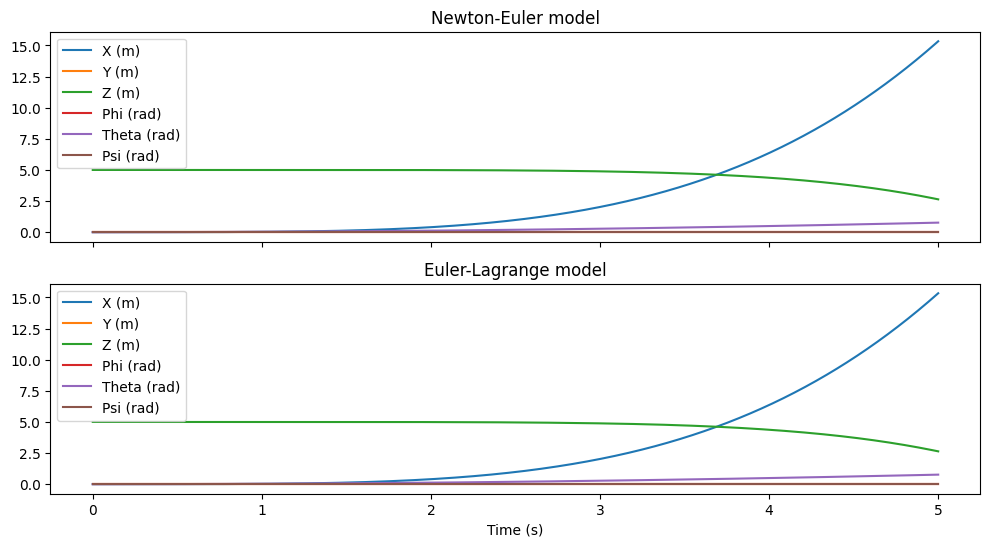

In [6]:
w2 = quadrotor_params['m']*9.81/(quadrotor_params['k']*4) # Squared speed of the propellers in order to hover ... 4*k*w^2 = m*g

#u = 4*[w2] # Hover
#u = [w2, w2*0.97, w2, w2*1.03] # Roll only
u = [w2*0.97, w2, w2*1.03, w2] # Pitch only
#u = [w2*0.97, w2*1.03, w2*0.97, w2*1.03] # Yaw only

quadrotor_ode_states = solve_ivp(lambda t, x: quadrotor_ode(t, x, **quadrotor_params, u=u),
                                t_span=(0, 5), y0=[0,0,5] + 9*[0], t_eval=np.linspace(0, 5, 1000))
quadrotor_dae_states = solve_dae(lambda t, x, x_dot: quadrotor_dae(t, x, x_dot, **quadrotor_params, u=u),
                                t_span=(0, 5), y0=[0,0,5] + 9*[0], y_dot0=np.zeros(12), t_eval=np.linspace(0, 5, 1000))

fig, axs = plt.subplots(2, 1, sharex=True)
for i, label in enumerate(['X (m)', 'Y (m)', 'Z (m)', 'Phi (rad)', 'Theta (rad)', 'Psi (rad)']):
    axs[0].plot(quadrotor_ode_states.t, quadrotor_ode_states.y[i], label=label)
    axs[1].plot(quadrotor_dae_states.t, quadrotor_dae_states.y[i], label=label)
for i, model in enumerate(['Newton-Euler model', 'Euler-Lagrange model']):
    axs[i].legend()
    axs[i].set_title(model)
axs[-1].set_xlabel('Time (s)')

### Oil well

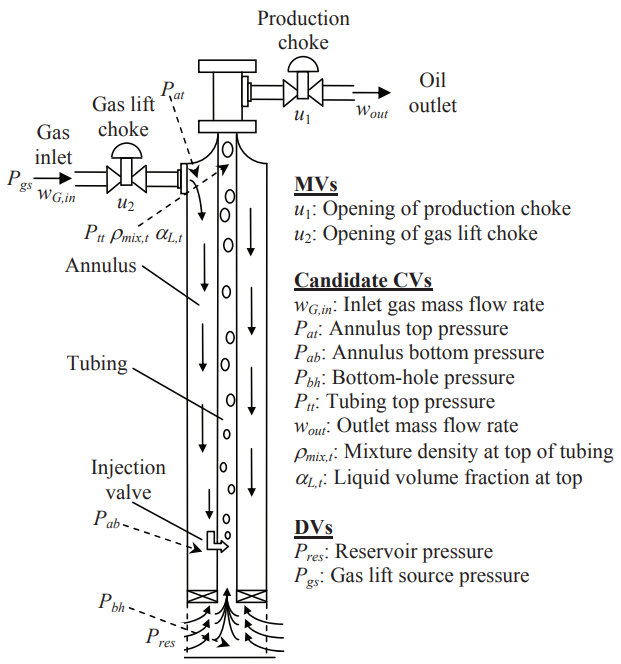

###### Image source: https://doi.org/10.3182/20120710-4-SG-2026.00110

States: $x = \begin{bmatrix} x_0 \\ x_1 \\ x_2 \end{bmatrix}$; Control actions: $u = \begin{bmatrix} u_1 \\ u_2 \end{bmatrix}$;
Algebraic states: $z = \begin{bmatrix} w_{G_in} \ P_{at} \ P_{ab} \ P_{bh} \ P_{tt} \ w_{out} \ \rho_{mix,t} \ \alpha_{L,t} \end{bmatrix}^T$

$x_0$ is the mass of gas in the annulus, $x_1$ is the mass of gas in the tubing, and $x_2$ is the mass of liquid in the tubing.

In [7]:
annulus_params = {
    'T_a': 348, # K
    'V_a': 64.34, # m^3
    'L_a': 2048, # m
    'K_gs': 9.98e-5,
    'K_inj': 1.4e-4,
}
gas_params = {
    'M_G': 16.7, # kg/mol
    'P_gs': 140, # bars
}
tubing_params = {
    'T_t': 350, # K
    'D_t': 0.124, # m
    'L_t': 1500, # m
    'V_t': 25.03, # m^3
    'epsilon': 2.8e-5, # m
    'K_pr': 2.9e-3,
    'P_out': 20, # bars
}
bottom_hole_params = {
    'S_bh': 0.0314, # m^2
    'L_bh': 75, # m
}
reservoir_params = {
    'P_res': 160, # bars
    'avg_w_res': 18, # kg/s
    'PI': 2.47e-6, # kg/s/Pa
    'GOR': 0,
}
oil_params = {
    'mu': 3.64e-3, # Pa.s
    'rho_L': 760, # kg/m^3
}

In [8]:
u_well = [0.5, 0.4] # Initial control actions ... [0.3, 0.4] stable, [0.5, 0.4] unstable
initial_guess = [
    3232, # mass of gas in the annulus ... if u0 = [0.3, 0.4], 3232 corresponds to the equilibrium
    269, # mass of gas in the tubing ... for u0 = [0.3, 0.4], 269 corresponds to the equilibrium
    10275, # mass of liquid in the tubing ... for u0 = [0.3, 0.4], 10275 corresponds to the equilibrium
]
simulation_time = 15*3600 # seconds

Text(0.5, 0, 'Time (h)')

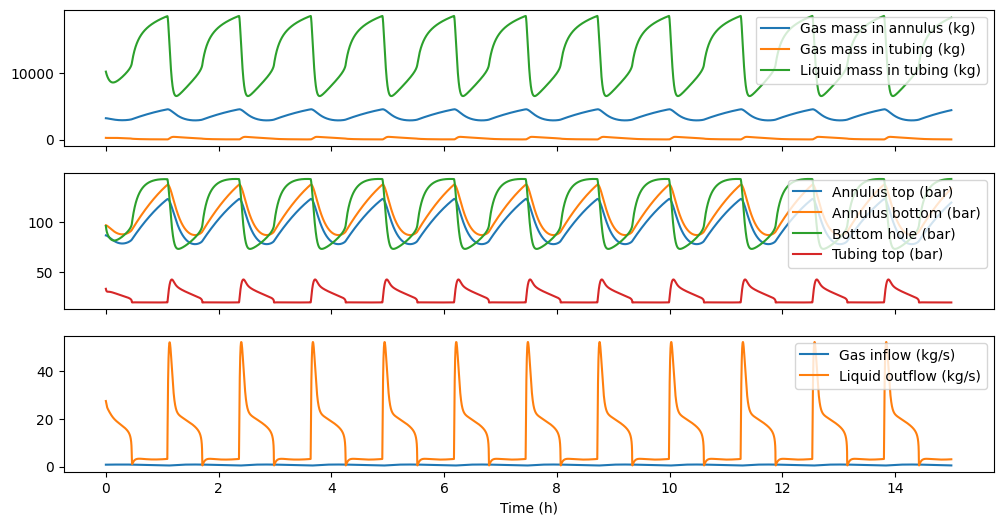

In [10]:
oil_well_states = solve_dae(lambda t, x, x_dot: oil_well(t, x, x_dot, **annulus_params, **gas_params, **tubing_params, **bottom_hole_params, **reservoir_params, **oil_params, u=u_well),
                            t_span=(0, simulation_time), y0=initial_guess + [0]*8, y_dot0=np.zeros(11), t_eval=np.linspace(0, simulation_time, simulation_time), rtol=1e-8)

# First sample is the initial guess. We remove it.
t = oil_well_states.t[:-1]/3600 # hours
x_0, x_1, x_2, w_G_in, P_at, P_ab, P_bh, P_tt, w_out, *_ = [state[1:] for state in oil_well_states.y]

# Regroup the states
masses = [x_0, x_1, x_2]
pressures = [P_at, P_ab, P_bh, P_tt]
flows = [w_G_in, w_out]

# Plot the states
fig, axs = plt.subplots(3, 1, sharex=True)
for var, label in zip(masses,['Gas mass in annulus (kg)', 'Gas mass in tubing (kg)', 'Liquid mass in tubing (kg)']):
    axs[0].plot(t, var, label=label)
for var, label in zip(pressures,['Annulus top (bar)', 'Annulus bottom (bar)', 'Bottom hole (bar)', 'Tubing top (bar)']):
    axs[1].plot(t, var, label=label)
for var, label in zip(flows,['Gas inflow (kg/s)', 'Liquid outflow (kg/s)']):
    axs[2].plot(t, var, label=label)

for ax in axs:
    ax.legend(loc='upper right')
axs[-1].set_xlabel('Time (h)')